# Download and Convert DTM for DJI RCs

#### Before using this script for Part 1 first download a meta4 file from the desired AOI:
#### e.g. for Bavaria: https://geodaten.bayern.de/opengeodata/OpenDataDetail.html?pn=dgm1
##### "Polygonale Auswahl" OR "Auswahl nach Verwaltungseinheiten"

In [9]:
from modules.metalink import fetch_meta4
from modules.tile_merger import *
from modules.functions import *
from pathlib import Path
from osgeo import gdal 
import numpy as np
import matplotlib.pyplot as plt

# recommended: adopt the future default
gdal.UseExceptions()

In [2]:
"""
Prepare DGM tile download, tile merge, and vertical datum and CRS conversion.

Inputs:
------
meta4             : Meta4 catalogue listing 1-m raster tiles: https://geodaten.bayern.de/opengeodata/OpenDataDetail.html?pn=dgm1
tiles             : Directory containing the individual tile TIFFs
mosaic            : UTM-32N mosaic of the tiles
geoid             : German Combined Geoid 2016 (v2023) 
out_path          : Target file—mosaic converted to ellipsoidal heights
"""

meta4   = Path(r"D:\Drohnendaten\15_FESMART\04_Metalink_dgm1m\dgm1.meta4")
tiles = Path(r"D:\Drohnendaten\15_FESMART\04_Metalink_dgm1m\dgm_tiles")
mosaic  = Path(r"D:\Drohnendaten\15_FESMART\04_Metalink_dgm1m\Hirschwald_DGM1m_UTM32N.tif")
geoid = Path(r"D:\Ecke_Simon\de_bkg_GCG2016v2023 (1).tif")
out_path   = Path(r"D:\Drohnendaten\15_FESMART\04_Metalink_dgm1m\Hirschwald_DGM1m_WGS84.tif")

# If you sit behind a proxy
PROXY   = "http://www-proxy.bayern.de:80"   # e.g. "http://proxy.mycorp.local:3128"

### Part 1: Download Metalink DTM Tiles & Merge Tiles (Skip if you already have a DTM)

In [3]:
# Download dtm tiles
await fetch_meta4(meta4, tiles, workers=8, proxy=PROXY)
print("  Finished – all mirrors checked and tiles verified")

tiles: 100%|███████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.20it/s]

  Finished – all mirrors checked and tiles verified


In [4]:
# Merge tiles
merge_streaming(tiles, mosaic)

tiles: 100%|███████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 35.08it/s]


✅  Mosaic written → D:\Drohnendaten\15_FESMART\04_Metalink_dgm1m\Hirschwald_DGM1m_UTM32N.tif


### Part 2: Convert DTM into WGS84 ellipsoidal heights 

In [5]:
# adds the geoid undulation to every raster cell, turning orthometric heights into ellipsoidal heights (above the WGS-84 reference ellipsoid)
ellip_arr, ellip_profile = add_geoid(mosaic, geoid)
tmp_path = mosaic.with_suffix(".ellip_tmp.tif")

with rasterio.open(tmp_path, "w", **ellip_profile) as dst:
    dst.write(ellip_arr, 1)

tmp_path


WindowsPath('D:/Drohnendaten/15_FESMART/04_Metalink_dgm1m/Hirschwald_DGM1m_UTM32N.ellip_tmp.tif')

In [6]:
# Reproject to geographic WGS-84 **keeping native resolution**
warp_opts = gdal.WarpOptions(
    dstSRS="EPSG:4326",            # target CRS: lat/long WGS-84
    resampleAlg="bilinear",        # smooth elevation when resampling
    creationOptions=[
        "COMPRESS=LZW",            # lossless compression
        "TILED=YES"                # internal tiling → COG-friendly
    ]
    # xRes / yRes omitted → GDAL keeps ~1 m native ground resolution
)

gdal.Warp(str(out_path), str(tmp_path), options=warp_opts)
print("✓ saved to", out_path)

✓ saved to D:\Drohnendaten\15_FESMART\04_Metalink_dgm1m\Hirschwald_DGM1m_WGS84.tif


In [7]:
# %% 7 – Clean up temp file
tmp_path.unlink(missing_ok=True)

### Check result!

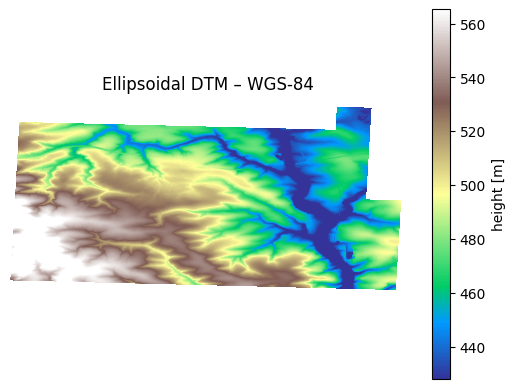

In [8]:
if __name__ == "__main__":
    with rasterio.open(out_path) as src:
        # 1) read as MaskedArray – nodata (-99999) is masked out
        arr = src.read(1, masked=True)          # <-- key line

        # 2) pick stretch limits on the *valid* pixels only
        vmin, vmax = np.nanpercentile(arr.compressed(), (5, 95))

        # 3) feed imshow either the masked array itself …
        #    (matplotlib treats masked cells as fully transparent)
        plt.imshow(arr, vmin=vmin, vmax=vmax, cmap="terrain")

        plt.title("Ellipsoidal DTM – WGS-84")
        plt.axis("off")
        plt.colorbar(label="height [m]")
        plt.show()
